# TPSL: Short term dip

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ta.trend import SMAIndicator
import time

In [7]:
# Temporary solution
import sys
sys.path.insert(0, '../..')
import useful_functions as uf

In [9]:
df = pd.read_csv("../../data/BTCUSDT-minute.csv")

In [10]:
df

,timestamp,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
0,2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183,1502942459999,7.564907e+03,3,0.075183,3.203909e+02,7960.540180
1,2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000,1502942519999,0.000000e+00,0,0.000000,0.000000e+00,7960.452630
2,2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,1502942579999,1.117543e+03,2,0.261074,1.117543e+03,7960.375295
3,2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,1502942639999,5.117185e+01,3,0.012008,5.117185e+01,7960.375295
4,2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,1502942699999,5.999993e+02,1,0.140796,5.999993e+02,7960.375295
...,...,...,...,...,...,...,...,...,...,...,...,...
1988733,2021-06-03 20:24:00,38665.26,38689.56,38655.91,38682.52,14.795718,1622751899999,5.722516e+05,457,5.929895,2.293488e+05,0.000000
1988734,2021-06-03 20:25:00,38682.52,38682.53,38643.07,38649.70,16.778473,1622751959999,6.486770e+05,563,6.614560,2.557099e+05,0.000000
1988735,2021-06-03 20:26:00,38649.69,38682.52,38649.69,38682.52,15.709853,1622752019999,6.074695e+05,566,11.004542,4.255326e+05,0.000000
1988736,2021-06-03 20:27:00,38682.52,38682.69,38640.40,38649.38,23.010205,1622752079999,8.894626e+05,590,7.261787,2.806922e+05,0.000000


## Target Generation

In [11]:
# df = df[1970000:1980000]

In [13]:
def get_target(df, span:int, tp:float, sl:float):
    """
    gets target. must have tp or greater within span and no sl in span
    tp: 1.5
    sl: 2.5
    """
    acc = [] #target column

    for i in range(len(df["close"])):
        close = df.iloc[i].close
        high = df.iloc[i].high
        low = df.iloc[i].low
        
        if i+span < len(df["close"]):
            tp_price = (1+tp/100)*close
            sl_price = (1-sl/100)*close
            high = max(df.iloc[i+1:i+span].high)
            low = min(df.iloc[i+1:i+span].low)
            
            if low<sl_price:
                acc.append(0)
            elif high>tp_price:
                acc.append(1)
            else:
                acc.append(0)
        else:
            acc.append(None)

    return acc
    

In [123]:
def get_target_even_faster(df, span:int, tp:float, sl:float):
    target = []
    sdf = df[['close','high','low']]
    
    i_high = sdf['high'][0:span].idxmax()
    i_low = sdf['low'][0:span].idxmin()
    
    start_time = time.time()
    
    for i in range(sdf.shape[0]):
        
        #progress tracker
        if i %100000 == 0:
            print('█', end="")
        
        if i+span+1 >= len(sdf['close']): 
            target.append(None)
            continue
            
        close = sdf['close'][i]
        tp_price = (1+tp/100)*close
        sl_price = (1-sl/100)*close
        
        
        if i_high+1 == i:
            i_high = sdf['high'][i+1:i+span].idxmax()
            high = sdf['high'][i_high]
        elif sdf['high'][i+span] > sdf['high'][i_high]:
            i_high = i+span
            high = sdf['high'][i+span]
        else:
            high = sdf['high'][i_high]
        
        if i_low+1 == i:
            i_low = sdf['low'][i+1:i+span].idxmin()
            low = sdf['low'][i_low]
        elif sdf['low'][i+span] < sdf['low'][i_low]:
            i_low = i+span
            low = sdf['low'][i+span]
        else:
            low = sdf['low'][i_low]
        
        
        target.append(1 if high>tp_price and low>sl_price else 0)
        
    print(' DONE in %s seconds' % (time.time() - start_time))
    return target

In [226]:
def get_target_y(df, span:int, tp:float, sl:float):
    
    target = []
    sdf = df[['close','high','low']]
    
    i_high = sdf['high'][0:span].idxmax()
    high = sdf['high'][i_high]
    i_low = sdf['low'][0:i_high].idxmin()
    low = sdf['low'][i_low]
    
    start_time = time.time()
    
    for i in range(sdf.shape[0]):
        
        #progress tracker
        if i %100000 == 0:
            print('█', end="")
        
        if i+span+1 >= len(sdf['close']): 
            target.append(None)
            continue
            
        close = sdf['close'][i]
        tp_price = (1+tp/100)*close
        sl_price = (1-sl/100)*close
        
        if i_high+1 == i:
            i_high = sdf['high'][i+1:i+span].idxmax()
            high = sdf['high'][i_high]
            
            if i+1 < i_high: 
                i_low = sdf['low'][i+1:i_high].idxmin()
                low = sdf['low'][i_low]
                
        elif sdf['high'][i+span] > sdf['high'][i_high]:
            i_high = i+span
            high = sdf['high'][i+span]
            
            if i+1 < i_high: 
                i_low = sdf['low'][i+1:i_high].idxmin()
                low = sdf['low'][i_low]
            
        elif i_low+1 == i:
            
            if i+1 < i_high: 
                i_low = sdf['low'][i+1:i_high].idxmin()
                low = sdf['low'][i_low]
            
        else:
            high = sdf['high'][i_high]
        
        target.append(1 if high>tp_price and low>sl_price else 0)
        
    print(' DONE in %s seconds' % (time.time() - start_time))
    return target

In [227]:
df["target"] = get_target_y(df, span=1000, tp=1.5, sl=2.5)

████████████████████ DONE in 51.40707993507385 seconds


In [114]:
df["target"] = get_target_even_faster(df, span=200, tp=1.5, sl=2.5)

████████████████████ DONE in 59.50685405731201 seconds


In [194]:
df[291000:291600]

,timestamp,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore,target,scatter_target
291000,2018-03-09 02:40:00,9019.00,9065.09,9004.00,9050.00,70.965176,1520563259999,641544.797127,603,46.907800,424044.478647,0.0,0.0,NaN
291001,2018-03-09 02:41:00,9050.00,9070.07,9010.07,9011.00,56.246796,1520563319999,508190.302508,382,17.869410,161744.778279,0.0,0.0,NaN
291002,2018-03-09 02:42:00,9010.10,9049.12,9010.07,9030.01,29.760545,1520563379999,268683.687496,236,25.093986,226572.462350,0.0,0.0,NaN
291003,2018-03-09 02:43:00,9030.97,9038.26,9010.07,9037.04,32.645047,1520563439999,294594.864218,233,16.723327,150931.247424,0.0,0.0,NaN
291004,2018-03-09 02:44:00,9038.76,9045.54,9018.93,9032.23,13.916454,1520563499999,125682.772204,169,10.121928,91416.921293,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291595,2018-03-09 12:35:00,8925.01,8934.01,8901.43,8920.00,28.977253,1520598959999,258569.336651,320,10.828628,96681.966330,0.0,0.0,8920.00
291596,2018-03-09 12:36:00,8920.01,8920.40,8901.43,8901.43,10.879826,1520599019999,96931.460546,180,3.901420,34778.592129,0.0,0.0,8901.43
291597,2018-03-09 12:37:00,8901.43,8909.96,8885.00,8897.00,21.605059,1520599079999,192274.804248,232,15.031878,133794.745373,0.0,0.0,8897.00
291598,2018-03-09 12:38:00,8893.00,8920.00,8889.06,8918.97,32.239334,1520599139999,286936.293537,320,21.221071,188851.289846,0.0,0.0,8918.97


## Target Plotting

In [228]:
df["scatter_target"] = list(map(lambda x, c: c if x == 1 else None, df["target"], df["close"]))

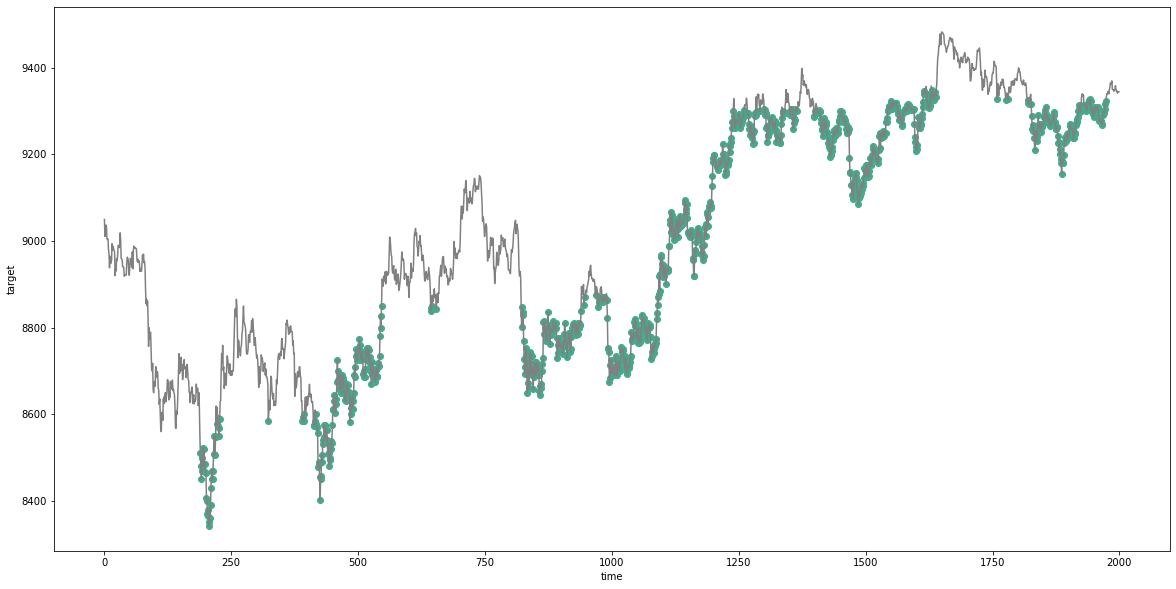

In [229]:
d = df[291000:293000]

fig,ax = plt.subplots(figsize=(20, 10))
ax.scatter(range(len(d)),
           d.scatter_target,
            color="#43aa8b")
# ax.axhline(y=0, color='darkgreen', linestyle='-')
ax.set_xlabel("time")
ax.set_ylabel("target")

# ax.tick_params(labelbottom=False)    
# ax.axes.xaxis.set_visible(False)

# ax2=ax.twinx()
ax.plot(list(d.close),
         color="grey")

# ax.set_ylabel("close")
# fig.legend(["a", "b", "c", "d"])
plt.show()

In [43]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objects as go

## Plotly

In [65]:
# d = df[1000000:]
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=d.index, y=d['close'], name='close'))
# fig.add_trace(go.Scatter(x=d.index, y=d['scatter_target'], name='target'))

# fig.show()

## Evaluation

In [230]:
df.target.value_counts(), df.target.value_counts()[1]/(df.target.value_counts()[0]+df.target.value_counts()[1])

(0.0    1078240
 1.0     909497
 Name: target, dtype: int64,
 0.45755399230381083)

In [92]:
df.to_csv("../data/BTCUSDT-minute-target-tpsl.csv", index=False)

In [66]:
#4

0.0    1988537
Name: target, dtype: int64